# Combining Datasets: concat and append

Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
`Series` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

Here we'll take a look at simple concatenation of `Series` and ``DataFrame``s with the `pd.concat` function; later we'll dive into more sophisticated in-memory merges and joins implemented in Pandas.

We begin with the standard imports:

In [ ]:
import pandas as pd
import numpy as np

For convenience, we'll define this function, which creates a `DataFrame` of a particular form that will be useful in the following examples:

In [ ]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special `_repr_html_` method, which IPython/Jupyter uses to implement its rich object display:

In [ ]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


The use of this will become clearer as we continue our discussion in the following section.

## Recall: Concatenation of NumPy Arrays

Concatenation of `Series` and `DataFrame` objects behaves similarly to concatenation of NumPy arrays, which can be done via the `np.concatenate` function, as discussed in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb).
Recall that with it, you can combine the contents of two or more arrays into a single array:

In [ ]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
np.concatenate([x, y, z])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The first argument is a list or tuple of arrays to concatenate.
Additionally, in the case of multidimensional arrays, it takes an `axis` keyword that allows you to specify the axis along which the result will be concatenated:

In [ ]:
x = [[1, 2],
     [3, 4]]
np.concatenate([x, x], axis=1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

## Simple Concatenation with pd.concat

The `pd.concat` function provides a similar syntax to `np.concatenate` but contains a number of options that we'll discuss momentarily:

```python
# Signature in Pandas v1.3.5
pd.concat(objs, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False,
          sort=False, copy=True)
```

`pd.concat` can be used for a simple concatenation of `Series` or `DataFrame` objects, just as `np.concatenate` can be used for simple concatenations of arrays:

In [ ]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

It also works to concatenate higher-dimensional objects, such as ``DataFrame``s:

In [ ]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
display('df1', 'df2', 'pd.concat([df1, df2])')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


It's default behavior is to concatenate row-wise within the `DataFrame` (i.e., `axis=0`).
Like `np.concatenate`, `pd.concat` allows specification of an axis along which concatenation will take place.
Consider the following example:

In [ ]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis='columns')")

df3
    A   B
0  A0  B0
1  A1  B1

df4
    C   D
0  C0  D0
1  C1  D1

pd.concat([df3, df4], axis='columns')
    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

We could have equivalently specified ``axis=1``; here we've used the more intuitive ``axis='columns'``.

### Duplicate Indices

One important difference between `np.concatenate` and `pd.concat` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this short example:

In [ ]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make indices match
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result.
While this is valid within ``DataFrame``s, the outcome is often undesirable.
`pd.concat` gives us a few ways to handle it.

#### Treating repeated indices as an error

If you'd like to simply verify that the indices in the result of `pd.concat` do not overlap, you can include the `verify_integrity` flag.
With this set to `True`, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

In [ ]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the `ignore_index` flag.
With this set to `True`, the concatenation will create a new integer index for the resulting `DataFrame`:

In [ ]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys

Another option is to use the `keys` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data:

In [ ]:
display('x', 'y', "pd.concat([x, y], keys=['x', 'y'])")

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys=['x', 'y'])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

We can use the tools discussed in [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb) to transform this multiply indexed `DataFrame` into the representation we're interested in.

### Concatenation with Joins

In the short examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and `pd.concat` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

In [ ]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

The default behavior is to fill entries for which no data is available with NA values.
To change this, we can adjust the `join` parameter of the `concat` function.
By default, the join is a union of the input columns (`join='outer'`), but we can change this to an intersection of the columns using `join='inner'`:

In [ ]:
display('df5', 'df6',
        "pd.concat([df5, df6], join='inner')")

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6], join='inner')
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

Another useful pattern is to use the `reindex` method before concatenation for finer control over which columns are dropped:

In [ ]:
pd.concat([df5, df6.reindex(df5.columns, axis=1)])

,A,B,C
1,A1,B1,C1
2,A2,B2,C2
3,NaN,B3,C3
4,NaN,B4,C4


### The append Method

Because direct array concatenation is so common, `Series` and `DataFrame` objects have an `append` method that can accomplish the same thing in fewer keystrokes.
For example, in place of `pd.concat([df1, df2])`, you can use `df1.append(df2)`:

In [ ]:
display('df1', 'df2', 'df1.append(df2)')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


Keep in mind that unlike the `append` and `extend` methods of Python lists, the `append` method in Pandas does not modify the original object; instead it creates a new object with the combined data.
It also is not a very efficient method, because it involves creation of a new index *and* data buffer.
Thus, if you plan to do multiple `append` operations, it is generally better to build a list of `DataFrame` objects and pass them all at once to the `concat` function.

In the next chapter, we'll look at a more powerful approach to combining data from multiple sources: the database-style merges/joins implemented in `pd.merge`.
For more information on `concat`, `append`, and related functionality, see the ["Merge, Join, Concatenate and Compare" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

# Combining Datasets: merge and join

One important feature offered by Pandas is its high-performance, in-memory join and merge operations, which you may be familiar with if you have ever worked with databases.
The main interface for this is the `pd.merge` function, and we'll see a few examples of how this can work in practice.

For convenience, we will again define the `display` function from the previous chapter after the usual imports:

In [ ]:
import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Relational Algebra

The behavior implemented in `pd.merge` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data that forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several fundamental operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building blocks in the `pd.merge` function and the related `join` method of `Series` and `DataFrame` objects.
As you will see, these let you efficiently link data from different sources.

## Categories of Joins

The `pd.merge` function implements a number of types of joins: *one-to-one*, *many-to-one*, and *many-to-many*.
All three types of joins are accessed via an identical call to the `pd.merge` interface; the type of join performed depends on the form of the input data.
We'll start with some simple examples of the three types of merges, and discuss detailed options a bit later.

### One-to-One Joins

Perhaps the simplest type of merge is the one-to-one join, which is in many ways similar to the column-wise concatenation you saw in [Combining Datasets: Concat & Append](03.06-Concat-And-Append.ipynb).
As a concrete example, consider the following two `DataFrame` objects, which contain information on several employees in a company:

In [ ]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering',
                              'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2')

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Jake,2012
3,Sue,2014


To combine this information into a single `DataFrame`, we can use the `pd.merge` function:

In [ ]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


The `pd.merge` function recognizes that each `DataFrame` has an `employee` column, and automatically joins using this column as a key.
The result of the merge is a new `DataFrame` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the `employee` column differs between `df1` and `df2`, and the `pd.merge` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the `left_index` and `right_index` keywords, discussed momentarily).

### Many-to-One Joins

Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting `DataFrame` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

In [ ]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

df3
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

df4
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve

pd.merge(df3, df4)
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve

The resulting `DataFrame` has an additional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs.

### Many-to-Many Joins

Many-to-many joins may be a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right arrays contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a `DataFrame` showing one or more skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any individual person:

In [ ]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'software', 'math',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,software
3,Engineering,math
4,HR,spreadsheets


These three types of joins can be used with other Pandas tools to implement a wide array of functionality.
But in practice, datasets are rarely as clean as the one we're working with here.
In the following section we'll consider some of the options provided by `pd.merge` that enable you to tune how the join operations work.

## Specification of the Merge Key

We've already seen the default behavior of `pd.merge`: it looks for one or more matching column names between the two inputs, and uses this as the key.
However, often the column names will not match so nicely, and `pd.merge` provides a variety of options for handling this.

### The on Keyword

Most simply, you can explicitly specify the name of the key column using the `on` keyword, which takes a column name or a list of column names:

In [ ]:
display('df1', 'df2', "pd.merge(df1, df2, on='employee')")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2, on='employee')
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

This option works only if both the left and right ``DataFrame``s have the specified column name.

### The left_on and right_on Keywords

At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee name is labeled as "name" rather than "employee".
In this case, we can use the `left_on` and `right_on` keywords to specify the two column names:

In [ ]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on="employee", right_on="name")')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1, df3, left_on="employee", right_on="name")
  employee        group  name  salary
0      Bob   Accounting   Bob   70000
1     Jake  Engineering  Jake   80000
2     Lisa  Engineering  Lisa  120000
3      Sue           HR   Sue   90000

The result has a redundant column that we can drop if desired—for example, by using the `DataFrame.drop()` method:

In [ ]:
pd.merge(df1, df3, left_on="employee", right_on="name").drop('name', axis=1)

,employee,group,salary
0,Bob,Accounting,70000
1,Jake,Engineering,80000
2,Lisa,Engineering,120000
3,Sue,HR,90000


### The left_index and right_index Keywords

Sometimes, rather than merging on a column, you would instead like to merge on an index.
For example, your data might look like this:

In [ ]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


You can use the index as the key for merging by specifying the `left_index` and/or `right_index` flags in `pd.merge()`:

In [ ]:
display('df1a', 'df2a',
        "pd.merge(df1a, df2a, left_index=True, right_index=True)")

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


For convenience, Pandas includes the `DataFrame.join()` method, which performs an index-based merge without extra keywords:

In [ ]:
df1a.join(df2a)

,group,hire_date
employee,,
Bob,Accounting,2008
Jake,Engineering,2012
Lisa,Engineering,2004
Sue,HR,2014


If you'd like to mix indices and columns, you can combine `left_index` with `right_on` or `left_on` with `right_index` to get the desired behavior:

In [ ]:
display('df1a', 'df3', "pd.merge(df1a, df3, left_index=True, right_on='name')")

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1a, df3, left_index=True, right_on='name')
         group  name  salary
0   Accounting   Bob   70000
1  Engineering  Jake   80000
2  Engineering  Lisa  120000
3           HR   Sue   90000

All of these options also work with multiple indices and/or multiple columns; the interface for this behavior is very intuitive.
For more information on this, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

## Specifying Set Arithmetic for Joins

In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.
This comes up when a value appears in one key column but not the other. Consider this example:

In [ ]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7)
   name   food drink
0  Mary  bread  wine

Here we have merged two datasets that have only a single "name" entry in common: Mary.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the `how` keyword, which defaults to `"inner"`:

In [ ]:
pd.merge(df6, df7, how='inner')

,name,food,drink
0,Mary,bread,wine


Other options for the `how` keyword are `'outer'`, `'left'`, and `'right'`.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

In [ ]:
display('df6', 'df7', "pd.merge(df6, df7, how='outer')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='outer')
     name   food drink
0   Peter   fish   NaN
1    Paul  beans   NaN
2    Mary  bread  wine
3  Joseph    NaN  beer

The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

In [ ]:
display('df6', 'df7', "pd.merge(df6, df7, how='left')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='left')
    name   food drink
0  Peter   fish   NaN
1   Paul  beans   NaN
2   Mary  bread  wine

The output rows now correspond to the entries in the left input. Using
`how='right'` works in a similar manner.

All of these options can be applied straightforwardly to any of the preceding join types.

## Overlapping Column Names: The suffixes Keyword

Last, you may end up in a case where your two input ``DataFrame``s have conflicting column names.
Consider this example:

In [ ]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name")
   name  rank_x  rank_y
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

Because the output would have two conflicting column names, the `merge` function automatically appends the suffixes ``_x`` and ``_y`` to make the output columns unique.
If these defaults are inappropriate, it is possible to specify a custom suffix using the ``suffixes`` keyword:

In [ ]:
pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])

,name,rank_L,rank_R
0,Bob,1,3
1,Jake,2,1
2,Lisa,3,4
3,Sue,4,2


These suffixes work in any of the possible join patterns, and also work if there are multiple overlapping columns.

For more information on these patterns, see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb), where we dive a bit deeper into relational algebra.
Also see the ["Merge, Join, Concatenate and Compare" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation for further discussion of these topics.

## Example: US States Data

Merge and join operations come up most often when combining data from different sources.
Here we will consider an example of some data about US states and their populations.
The data files can be found at [http://github.com/jakevdp/data-USstates](http://github.com/jakevdp/data-USstates):

In [ ]:
# Following are commands to download the data
# repo = "https://raw.githubusercontent.com/jakevdp/data-USstates/master"
# !cd data && curl -O {repo}/state-population.csv
# !cd data && curl -O {repo}/state-areas.csv
# !cd data && curl -O {repo}/state-abbrevs.csv

Let's take a look at the three datasets, using the Pandas ``read_csv`` function:

In [ ]:
pop = pd.read_csv('data/state-population.csv')
areas = pd.read_csv('data/state-areas.csv')
abbrevs = pd.read_csv('data/state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Given this information, say we want to compute a relatively straightforward result: rank US states and territories by their 2010 population density.
We clearly have the data here to find this result, but we'll have to combine the datasets to do so.

We'll start with a many-to-one merge that will give us the full state names within the population `DataFrame`.
We want to merge based on the `state/region`  column of `pop` and the `abbreviation` column of `abbrevs`.
We'll use `how='outer'` to make sure no data is thrown away due to mismatched labels:

In [ ]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged = merged.drop('abbreviation', axis=1) # drop duplicate info
merged.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

In [ ]:
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

Some of the ``population`` values are null; let's figure out which these are!

In [ ]:
merged[merged['population'].isnull()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available in the original source.

More importantly, we see that some of the new `state` entries are also null, which means that there was no corresponding entry in the `abbrevs` key!
Let's figure out which regions lack this match:

In [ ]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [ ]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

No more nulls in the `state` column: we're all set!

Now we can merge the result with the area data using a similar procedure.
Examining our results, we will want to join on the `state` column in both:

In [ ]:
final = pd.merge(merged, areas, on='state', how='left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Again, let's check for nulls to see if there were any mismatches:

In [ ]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [ ]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [ ]:
final.dropna(inplace=True)
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2010, and the total population.
We'll use the `query` function to do this quickly (this requires the NumExpr package to be installed; see [High-Performance Pandas: `eval()` and `query()`](03.12-Performance-Eval-and-Query.ipynb)):

In [ ]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state, and then compute the result:

In [ ]:
data2010.set_index('state', inplace=True)
density = data2010['population'] / data2010['area (sq. mi)']

In [ ]:
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

The result is a ranking of US states, plus Washington, DC, and Puerto Rico, in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [ ]:
density.tail()

state
South Dakota    10.583512
North Dakota     9.537565
Montana          6.736171
Wyoming          5.768079
Alaska           1.087509
dtype: float64

We see that the least dense state, by far, is Alaska, averaging slightly over one resident per square mile.

This type of data merging is a common task when trying to answer questions using real-world data sources.
I hope that this example has given you an idea of some of the ways you can combine the tools we've covered in order to gain insight from your data!

# Aggregation and Grouping

A fundamental piece of many data analysis tasks is efficient summarization: computing aggregations like `sum`, `mean`, `median`, `min`, and `max`, in which a single number summarizes aspects of a potentially large dataset.
In this chapter, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays to more sophisticated operations based on the concept of a `groupby`.

For convenience, we'll use the same `display` magic function that we used in the previous chapters:

In [ ]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/) (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets*, or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [ ]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [ ]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


This has some details on the 1,000+ extrasolar planets discovered up to 2014.

## Simple Aggregation in Pandas

In ["Aggregations: Min, Max, and Everything In Between"](02.04-Computation-on-arrays-aggregates.ipynb), we explored some of the data aggregations available for NumPy arrays.
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [ ]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [ ]:
ser.sum()

2.811925491708157

In [ ]:
ser.mean()

0.5623850983416314

For a `DataFrame`, by default the aggregates return results within each column:

In [ ]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [ ]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

By specifying the `axis` argument, you can instead aggregate within each row:

In [ ]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas `Series` and `DataFrame` objects include all of the common aggregates mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb); in addition, there is a convenience method, `describe`, that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [ ]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This method helps us understand the overall properties of a dataset.
For example, we see in the `year` column that although exoplanets were discovered as far back as 1989, half of all planets in the dataset were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which aimed to find eclipsing planets around other stars using a specially designed space telescope.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Returns                         |
|--------------------------|---------------------------------|
| ``count``                | Total number of items           |
| ``first``, ``last``      | First and last item             |
| ``mean``, ``median``     | Mean and median                 |
| ``min``, ``max``         | Minimum and maximum             |
| ``std``, ``var``         | Standard deviation and variance |
| ``mad``                  | Mean absolute deviation         |
| ``prod``                 | Product of all items            |
| ``sum``                  | Sum of all items                |

These are all methods of `DataFrame` and `Series` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the `groupby` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## groupby: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called `groupby` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, Apply, Combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

![](images/03.08-split-apply-combine.png)

([figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Split-Apply-Combine))

This illustrates what the `groupby` operation accomplishes:

- The *split* step involves breaking up and grouping a `DataFrame` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the `groupby` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the `groupby` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather can think about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in the following figure.
We'll start by creating the input `DataFrame`:

In [ ]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic split-apply-combine operation can be computed with the `groupby` method of the `DataFrame`, passing the name of the desired key column:

In [ ]:
df.groupby('key')

Notice that what is returned is a `DataFrameGroupBy` object, not a set of `DataFrame` objects.
This object is where the magic is: you can think of it as a special view of the `DataFrame`, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this `DataFrameGroupBy` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [ ]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


The `sum` method is just one possibility here; you can apply most Pandas or NumPy aggregation functions, as well as most `DataFrame` operations, as you will see in the following discussion.

### The GroupBy Object

The `GroupBy` object is a flexible abstraction: in many ways, it can be treated as simply a collection of ``DataFrame``s, though it is doing more sophisticated things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a `GroupBy` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in the next section, but before that let's take a look at some of the other functionality that can be used with the basic `GroupBy` operation.

#### Column indexing

The `GroupBy` object supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object.
For example:

In [ ]:
planets.groupby('method')

In [ ]:
planets.groupby('method')['orbital_period']

Here we've selected a particular `Series` group from the original `DataFrame` group by reference to its column name.
As with the `GroupBy` object, no computation is done until we call some aggregate on the object:

In [ ]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The `GroupBy` object supports direct iteration over the groups, returning each group as a `Series` or `DataFrame`:

In [ ]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for manual inspection of groups for the sake of debugging, but it is often much faster to use the built-in `apply` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the `GroupBy` object will be passed through and called on the groups, whether they are `DataFrame` or `Series` objects.
For example, using the `describe` method is equivalent to calling `describe` on the `DataFrame` representing each group:

In [ ]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.0
       Eclipse Timing Variations           9.0
       Imaging                            38.0
       Microlensing                       23.0
       Orbital Brightness Modulation       3.0
                                         ...  
max    Pulsar Timing                    2011.0
       Pulsation Timing Variations      2007.0
       Radial Velocity                  2014.0
       Transit                          2014.0
       Transit Timing Variations        2014.0
Length: 80, dtype: float64

Looking at this table helps us to better understand the data: for example, the vast majority of planets until 2014 were discovered by the Radial Velocity and Transit methods, though the latter method became common more recently.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

Notice that these dispatch methods are applied *to each individual group*, and the results are then combined within `GroupBy` and returned.
Again, any valid `DataFrame`/`Series` method can be called in a similar manner on the corresponding `GroupBy` object.

### Aggregate, Filter, Transform, Apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, `GroupBy` objects have `aggregate`, `filter`, `transform`, and `apply` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

You're now familiar with `GroupBy` aggregations with `sum`, `median`, and the like, but the `aggregate` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all of these:

In [ ]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another common pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [ ]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [ ]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()",
        "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

The filter function should return a Boolean value specifying whether the group passes the filtering. Here, because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [ ]:
def center(x):
    return x - x.mean()
df.groupby('key').transform(center)

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


#### The apply method

The `apply` method lets you apply an arbitrary function to the group results.
The function should take a `DataFrame` and returns either a Pandas object (e.g., `DataFrame`, `Series`) or a scalar; the behavior of the combine step will be tailored to the type of output returned.

For example, here is an `apply` operation that normalizes the first column by the sum of the second:

In [ ]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

df.groupby('key').apply(norm_by_data2)

,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3
3,A,0.375000,3
4,B,0.571429,7
5,C,0.416667,9


`apply` within a `GroupBy` is flexible: the only criterion is that the function takes a `DataFrame` and returns a Pandas object or scalar. What you do in between is up to you!

### Specifying the Split Key

In the simple examples presented before, we split the `DataFrame` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the `DataFrame`. For example:

In [ ]:
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

,data1,data2
0,7,17
1,4,3
2,4,7


Of course, this means there's another, more verbose way of accomplishing the `df.groupby('key')` from before:

In [ ]:
df.groupby(df['key']).sum()

,data1,data2
key,,
A,3,8
B,5,7
C,7,12


#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [ ]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
consonant,12,19


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [ ]:
df2.groupby(str.lower).mean()

,data1,data2
key,,
a,1.5,4.0
b,2.5,3.5
c,3.5,6.0


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [ ]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
key,key,,
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### Grouping Example

As an example of this, in a few lines of Python code we can put all these together and count discovered planets by method and by decade:

In [ ]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets: we quickly gain a coarse understanding of when and how extrasolar planets were detected in the years after the first discovery.

I would suggest digging into these few lines of code and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.

# Pivot Tables

We have seen how the `groupby` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and `groupby` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of `groupby` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


As the output shows, this contains a number of data points on each passenger on that ill-fated voyage, including sex, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to sex, survival status, or some combination thereof.
If you read the previous chapter, you might be tempted to apply a `groupby` operation—for example, let's look at survival rate by sex:

In [ ]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This gives us some initial insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival rates by both sex and, say, class.
Using the vocabulary of `groupby`, we might proceed using a process like this:
we first *group by* class and sex, then *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and finally *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both sex and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional `groupby` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multidimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the `DataFrame.pivot_table` method:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the manual `groupby` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both higher classes and people recorded as females in the
data. First-class females survived with near certainty (hi, Rose!), while only one in eight or so third-class males survived (sorry, Jack!).

### Multilevel Pivot Tables

Just as in a `groupby`, the grouping in pivot tables can be specified with multiple levels and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the `pd.cut` function:

In [ ]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid, using `pd.qcut` to automatically compute quantiles:

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional Pivot Table Options

The full call signature of the `DataFrame.pivot_table` method is as follows:

```python
# call signature as of Pandas 1.3.5
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All', observed=False,
                      sort=True)
```

We've already seen examples of the first three arguments; here we'll take a quick look at some of the remaining ones.
Two of the options, `fill_value` and `dropna`, have to do with missing data and are fairly straightforward; I will not show examples of them here.

The `aggfunc` keyword controls what type of aggregation is applied, which is a mean by default.
As with `groupby`, the aggregation specification can be a string representing one of several common choices (`'sum'`, `'mean'`, `'count'`, `'min'`, `'max'`, etc.) or a function that implements an aggregation (e.g., `np.sum()`, `min()`, `sum()`, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the desired options:

In [ ]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the `values` keyword; when specifying a mapping for `aggfunc`, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here, this automatically gives us information about the class-agnostic survival rate by sex, the sex-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the `margins_name` keyword; it defaults to `"All"`.

## Example: Birthrate Data

As another example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, the [blog post on signal processing using Gaussian processes](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

[^1]: The CDC dataset used in this section uses the sex assigned at birth, which it calls "gender," and limits the data to male and female. While gender is a spectrum independent of biology, I will be using the same terminology while discussing this dataset for consistency and clarity.

In [ ]:
# shell command to download the data:
# !cd data && curl -O \
# https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [ ]:
births = pd.read_csv('data/births.csv')

Taking a look at the data, we see that it's relatively simple—it contains the number of births grouped by date and gender:

In [ ]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


We can start to understand this data a bit more by using a pivot table.
Let's add a `decade` column, and take a look at male and female births as a function of decade:

In [ ]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year, as shown in the following figure (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

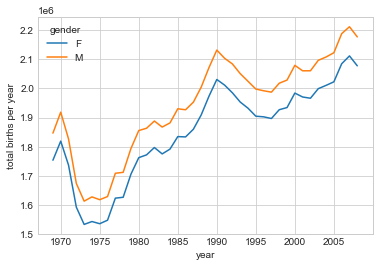

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
births.pivot_table(
    'births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and the `plot` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [ ]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample standard deviation, where the 0.74 comes from the interquartile range of a Gaussian distribution (you can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: [*Statistics, Data Mining, and Machine Learning in Astronomy*](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) (Princeton University Press)).

With this, we can use the `query` method (discussed further in [High-Performance Pandas: `eval()` and `query()`](03.12-Performance-Eval-and-Query.ipynb)) to filter out rows with births outside these values:

In [ ]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Next we set the `day` column to integers; previously it had been a string column because some columns in the dataset contained the value `'null'`:

In [ ]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

Finally, we can combine the day, month, and year to create a date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

In [ ]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this, we can plot births by weekday for several decades (see the following figure):

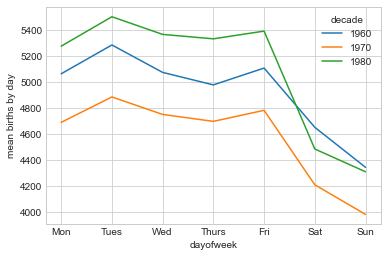

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set(xticks=range(7),
              xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because starting in 1989, the CDC data contains only the month of birth.

Another interesting view is to plot the mean number of births by the day of the year.
Let's first group the data by month and day separately:

In [ ]:
births_by_date = births.pivot_table('births',
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

The result is a multi-index over months and days.
To make this visualizable, let's turn these months and days into dates by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!):

In [ ]:
from datetime import datetime
births_by_date.index = [datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the `plot` method to plot the data. It reveals some interesting trends, as you can see in the following figure:

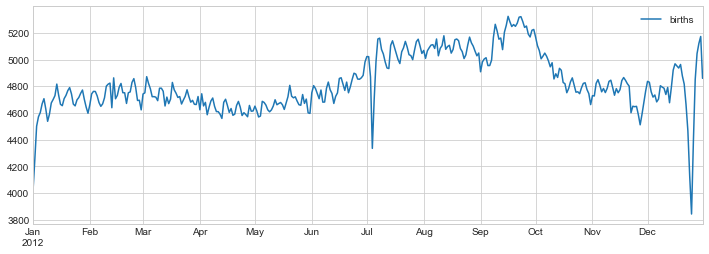

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day), although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion of this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb), where we will use Matplotlib's tools to annotate this plot.

Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets.
We will see some more sophisticated applications of these data manipulations in future chapters!

# Vectorized String Operations

One strength of Python is its relative ease in handling and manipulating string data.
Pandas builds on this and provides a comprehensive set of *vectorized string operations* that are an important part of the type of munging required when working with (read: cleaning up) real-world data.
In this chapter, we'll walk through some of the Pandas string operations, and then take a look at using them to partially clean up a very messy dataset of recipes collected from the internet.

## Introducing Pandas String Operations

We saw in previous chapters how tools like NumPy and Pandas generalize arithmetic operations so that we can easily and quickly perform the same operation on many array elements. For example:

In [ ]:
import numpy as np
x = np.array([2, 3, 5, 7, 11, 13])
x * 2

array([ 4,  6, 10, 14, 22, 26])

This *vectorization* of operations simplifies the syntax of operating on arrays of data: we no longer have to worry about the size or shape of the array, but just about what operation we want done.
For arrays of strings, NumPy does not provide such simple access, and thus you're stuck using a more verbose loop syntax:

In [ ]:
data = ['peter', 'Paul', 'MARY', 'gUIDO']
[s.capitalize() for s in data]

['Peter', 'Paul', 'Mary', 'Guido']

This is perhaps sufficient to work with some data, but it will break if there are any missing values, so this approach requires putting in extra checks:

In [ ]:
data = ['peter', 'Paul', None, 'MARY', 'gUIDO']
[s if s is None else s.capitalize() for s in data]

['Peter', 'Paul', None, 'Mary', 'Guido']

This kind of manual approach is not only verbose and inconvenient, it can be error-prone.

Pandas includes features to address both this need for vectorized string operations and the need for correctly handling missing data via the `str` attribute of Pandas `Series` and `Index` objects containing strings.
So, for example, if we create a Pandas `Series` with this data we can directly call the `str.capitalize` method, which has missing value handling built in:

In [ ]:
import pandas as pd
names = pd.Series(data)
names.str.capitalize()

0    Peter
1     Paul
2     None
3     Mary
4    Guido
dtype: object

## Tables of Pandas String Methods

If you have a good understanding of string manipulation in Python, most of the Pandas string syntax is intuitive enough that it's probably sufficient to just list the available methods. We'll start with that here, before diving deeper into a few of the subtleties.
The examples in this section use the following `Series` object:

In [ ]:
monte = pd.Series(['Graham Chapman', 'John Cleese', 'Terry Gilliam',
                   'Eric Idle', 'Terry Jones', 'Michael Palin'])

### Methods Similar to Python String Methods

Nearly all of Python's built-in string methods are mirrored by a Pandas vectorized string method. Here is a list of Pandas `str` methods that mirror Python string methods:

|           |                |                |                |
|-----------|----------------|----------------|----------------|
|`len()`    | `lower()`      | `translate()`  | `islower()`    |
|`ljust()`  | `upper()`      | `startswith()` | `isupper()`    |
|`rjust()`  | `find()`       | `endswith()`   | `isnumeric()`  |
|`center()` | `rfind()`      | `isalnum()`    | `isdecimal()`  |
|`zfill()`  | `index()`      | `isalpha()`    | `split()`      |
|`strip()`  | `rindex()`     | `isdigit()`    | `rsplit()`     |
|`rstrip()` | `capitalize()` | `isspace()`    | `partition()`  |
|`lstrip()` | `swapcase()`   | `istitle()`    | `rpartition()` |

Notice that these have various return values. Some, like `lower`, return a series of strings:

In [ ]:
monte.str.lower()

0    graham chapman
1       john cleese
2     terry gilliam
3         eric idle
4       terry jones
5     michael palin
dtype: object

But some others return numbers:

In [ ]:
monte.str.len()

0    14
1    11
2    13
3     9
4    11
5    13
dtype: int64

Or Boolean values:

In [ ]:
monte.str.startswith('T')

0    False
1    False
2     True
3    False
4     True
5    False
dtype: bool

Still others return lists or other compound values for each element:

In [ ]:
monte.str.split()

0    [Graham, Chapman]
1       [John, Cleese]
2     [Terry, Gilliam]
3         [Eric, Idle]
4       [Terry, Jones]
5     [Michael, Palin]
dtype: object

We'll see further manipulations of this kind of series-of-lists object as we continue our discussion.

### Methods Using Regular Expressions

In addition, there are several methods that accept regular expressions (regexps) to examine the content of each string element, and follow some of the API conventions of Python's built-in `re` module:

| Method    | Description |
|-----------|-------------|
| `match`   | Calls `re.match` on each element, returning a Boolean. |
| `extract` | Calls `re.match` on each element, returning matched groups as strings.|
| `findall` | Calls `re.findall` on each element |
| `replace` | Replaces occurrences of pattern with some other string|
| `contains`| Calls `re.search` on each element, returning a boolean |
| `count`   | Counts occurrences of pattern|
| `split`   | Equivalent to `str.split`, but accepts regexps |
| `rsplit`  | Equivalent to `str.rsplit`, but accepts regexps |

With these, we can do a wide range of operations.
For example, we can extract the first name from each element by asking for a contiguous group of characters at the beginning of each element:

In [ ]:
monte.str.extract('([A-Za-z]+)', expand=False)

0     Graham
1       John
2      Terry
3       Eric
4      Terry
5    Michael
dtype: object

Or we can do something more complicated, like finding all names that start and end with a consonant, making use of the start-of-string (`^`) and end-of-string (`$`) regular expression characters:

In [ ]:
monte.str.findall(r'^[^AEIOU].*[^aeiou]$')

0    [Graham Chapman]
1                  []
2     [Terry Gilliam]
3                  []
4       [Terry Jones]
5     [Michael Palin]
dtype: object

The ability to concisely apply regular expressions across `Series` or `DataFrame` entries opens up many possibilities for analysis and cleaning of data.

### Miscellaneous Methods
Finally, there are some miscellaneous methods that enable other convenient operations:

| Method | Description |
|--------|-------------|
| `get` | Indexes each element |
| `slice` | Slices each element|
| `slice_replace` | Replaces slice in each element with the passed value|
| `cat`      | Concatenates strings|
| `repeat` | Repeats values |
| `normalize` | Returns Unicode form of strings |
| `pad` | Adds whitespace to left, right, or both sides of strings|
| `wrap` | Splits long strings into lines with length less than a given width|
| `join` | Joins strings in each element of the `Series` with the passed separator|
| `get_dummies` | Extracts dummy variables as a `DataFrame` |

#### Vectorized item access and slicing

The `get` and `slice` operations, in particular, enable vectorized element access from each array.
For example, we can get a slice of the first three characters of each array using `str.slice(0, 3)`.
Note that this behavior is also available through Python's normal indexing syntax; for example, `df.str.slice(0, 3)` is equivalent to `df.str[0:3]`:

In [ ]:
monte.str[0:3]

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
dtype: object

Indexing via `df.str.get(i)` and `df.str[i]` are likewise similar.

These indexing methods also let you access elements of arrays returned by `split`.
For example, to extract the last name of each entry, we can combine `split` with `str` indexing:

In [ ]:
monte.str.split().str[-1]

0    Chapman
1     Cleese
2    Gilliam
3       Idle
4      Jones
5      Palin
dtype: object

#### Indicator variables

Another method that requires a bit of extra explanation is the `get_dummies` method.
This is useful when your data has a column containing some sort of coded indicator.
For example, we might have a dataset that contains information in the form of codes, such as A = "born in America," B = "born in the United Kingdom," C = "likes cheese," D = "likes spam":

In [ ]:
full_monte = pd.DataFrame({'name': monte,
                           'info': ['B|C|D', 'B|D', 'A|C',
                                    'B|D', 'B|C', 'B|C|D']})
full_monte

,name,info
0,Graham Chapman,B|C|D
1,John Cleese,B|D
2,Terry Gilliam,A|C
3,Eric Idle,B|D
4,Terry Jones,B|C
5,Michael Palin,B|C|D


The `get_dummies` routine lets us split out these indicator variables into a `DataFrame`:

In [ ]:
full_monte['info'].str.get_dummies('|')

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1


With these operations as building blocks, you can construct an endless range of string processing procedures when cleaning your data.

We won't dive further into these methods here, but I encourage you to read through ["Working with Text Data"](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html) in the Pandas online documentation, or to refer to the resources listed in [Further Resources](03.13-Further-Resources.ipynb).

## Example: Recipe Database

These vectorized string operations become most useful in the process of cleaning up messy, real-world data.
Here I'll walk through an example of that, using an open recipe database compiled from various sources on the web.
Our goal will be to parse the recipe data into ingredient lists, so we can quickly find a recipe based on some ingredients we have on hand. The scripts used to compile this can be found at https://github.com/fictivekin/openrecipes, and the link to the most recent version of the database is found there as well.

This database is about 30 MB, and can be downloaded and unzipped with these commands:

In [ ]:
# repo = "https://raw.githubusercontent.com/jakevdp/open-recipe-data/master"
# !cd data && curl -O {repo}/recipeitems.json.gz
# !gunzip data/recipeitems.json.gz

The database is in JSON format, so we will use `pd.read_json` to read it (`lines=True` is required for this dataset because each line of the file is a JSON entry):

In [ ]:
recipes = pd.read_json('data/recipeitems.json', lines=True)
recipes.shape

(173278, 17)

We see there are nearly 175,000 recipes, and 17 columns.
Let's take a look at one row to see what we have:

In [ ]:
recipes.iloc[0]

_id                                {'$oid': '5160756b96cc62079cc2db15'}
name                                    Drop Biscuits and Sausage Gravy
ingredients           Biscuits\n3 cups All-purpose Flour\n2 Tablespo...
url                   http://thepioneerwoman.com/cooking/2013/03/dro...
image                 http://static.thepioneerwoman.com/cooking/file...
ts                                             {'$date': 1365276011104}
cookTime                                                          PT30M
source                                                  thepioneerwoman
recipeYield                                                          12
datePublished                                                2013-03-11
prepTime                                                          PT10M
description           Late Saturday afternoon, after Marlboro Man ha...
totalTime                                                           NaN
creator                                                         

There is a lot of information there, but much of it is in a very messy form, as is typical of data scraped from the web.
In particular, the ingredient list is in string format; we're going to have to carefully extract the information we're interested in.
Let's start by taking a closer look at the ingredients:

In [ ]:
recipes.ingredients.str.len().describe()

count    173278.000000
mean        244.617926
std         146.705285
min           0.000000
25%         147.000000
50%         221.000000
75%         314.000000
max        9067.000000
Name: ingredients, dtype: float64

The ingredient lists average 250 characters long, with a minimum of 0 and a maximum of nearly 10,000 characters!

Just out of curiosity, let's see which recipe has the longest ingredient list:

In [ ]:
recipes.name[np.argmax(recipes.ingredients.str.len())]

'Carrot Pineapple Spice &amp; Brownie Layer Cake with Whipped Cream &amp; Cream Cheese Frosting and Marzipan Carrots'

We can do other aggregate explorations; for example, we can see how many of the recipes are for breakfast foods (using regular expression syntax to match both lowercase and capital letters):

In [ ]:
recipes.description.str.contains('[Bb]reakfast').sum()

3524

Or how many of the recipes list cinnamon as an ingredient:

In [ ]:
recipes.ingredients.str.contains('[Cc]innamon').sum()

10526

We could even look to see whether any recipes misspell the ingredient as "cinamon":

In [ ]:
recipes.ingredients.str.contains('[Cc]inamon').sum()

11

This is the type of data exploration that is possible with Pandas string tools.
It is data munging like this that Python really excels at.

### A Simple Recipe Recommender

Let's go a bit further, and start working on a simple recipe recommendation system: given a list of ingredients, we want to find any recipes that use all those ingredients.
While conceptually straightforward, the task is complicated by the heterogeneity of the data: there is no easy operation, for example, to extract a clean list of ingredients from each row.
So, we will cheat a bit: we'll start with a list of common ingredients, and simply search to see whether they are in each recipe's ingredient list.
For simplicity, let's just stick with herbs and spices for the time being:

In [ ]:
spice_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
              'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']

We can then build a Boolean `DataFrame` consisting of `True` and `False` values, indicating whether each ingredient appears in the list:

In [ ]:
import re
spice_df = pd.DataFrame({
    spice: recipes.ingredients.str.contains(spice, re.IGNORECASE)
    for spice in spice_list})
spice_df.head()

,salt,pepper,oregano,sage,parsley,rosemary,tarragon,thyme,paprika,cumin
0,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


Now, as an example, let's say we'd like to find a recipe that uses parsley, paprika, and tarragon.
We can compute this very quickly using the `query` method of ``DataFrame``s, discussed further in [High-Performance Pandas: `eval()` and `query()`](03.12-Performance-Eval-and-Query.ipynb):

In [ ]:
selection = spice_df.query('parsley & paprika & tarragon')
len(selection)

10

We find only 10 recipes with this combination. Let's use the index returned by this selection to discover the names of those recipes:

In [ ]:
recipes.name[selection.index]

2069      All cremat with a Little Gem, dandelion and wa...
74964                         Lobster with Thermidor butter
93768      Burton's Southern Fried Chicken with White Gravy
113926                     Mijo's Slow Cooker Shredded Beef
137686                     Asparagus Soup with Poached Eggs
140530                                 Fried Oyster Po’boys
158475                Lamb shank tagine with herb tabbouleh
158486                 Southern fried chicken in buttermilk
163175            Fried Chicken Sliders with Pickles + Slaw
165243                        Bar Tartine Cauliflower Salad
Name: name, dtype: object

Now that we have narrowed down our recipe selection from 175,000 to 10, we are in a position to make a more informed decision about what we'd like to cook for dinner.

### Going Further with Recipes

Hopefully this example has given you a bit of a flavor (heh) of the types of data cleaning operations that are efficiently enabled by Pandas string methods.
Of course, building a robust recipe recommendation system would require a *lot* more work!
Extracting full ingredient lists from each recipe would be an important piece of the task; unfortunately, the wide variety of formats used makes this a relatively time-consuming process.
This points to the truism that in data science, cleaning and munging of real-world data often comprises the majority of the work—and Pandas provides the tools that can help you do this efficiently.

# Working with Time Series

Pandas was originally developed in the context of financial modeling, so as you might expect, it contains an extensive set of tools for working with dates, times, and time-indexed data.
Date and time data comes in a few flavors, which we will discuss here:

- *Timestamps* reference particular moments in time (e.g., July 4th, 2021 at 7:00 a.m.).
- *Time intervals* and *periods* reference a length of time between a particular beginning and end point; for example, the month of June 2021. Periods usually reference a special case of time intervals in which each interval is of uniform length and does not overlap (e.g., 24-hour-long periods comprising days).
- *Time deltas* or *durations* reference an exact length of time (e.g., a duration of 22.56 seconds).

This chapter will introduce how to work with each of these types of date/time data in Pandas.
This is by no means a complete guide to the time series tools available in Python or Pandas, but instead is intended as a broad overview of how you as a user should approach working with time series.
We will start with a brief discussion of tools for dealing with dates and times in Python, before moving more specifically to a discussion of the tools provided by Pandas.
After listing some resources that go into more depth, we will review some short examples of working with time series data in Pandas.

## Dates and Times in Python

The Python world has a number of available representations of dates, times, deltas, and time spans.
While the time series tools provided by Pandas tend to be the most useful for data science applications, it is helpful to see their relationship to other tools used in Python.

### Native Python Dates and Times: datetime and dateutil

Python's basic objects for working with dates and times reside in the built-in `datetime` module.
Along with the third-party `dateutil` module, you can use this to quickly perform a host of useful functionalities on dates and times.
For example, you can manually build a date using the `datetime` type:

In [ ]:
from datetime import datetime
datetime(year=2021, month=7, day=4)

datetime.datetime(2021, 7, 4, 0, 0)

Or, using the `dateutil` module, you can parse dates from a variety of string formats:

In [ ]:
from dateutil import parser
date = parser.parse("4th of July, 2021")
date

datetime.datetime(2021, 7, 4, 0, 0)

Once you have a `datetime` object, you can do things like printing the day of the week:

In [ ]:
date.strftime('%A')

'Sunday'

Here we've used one of the standard string format codes for printing dates (`'%A'`), which you can read about in the [`strftime` section](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) of Python's [`datetime` documentation](https://docs.python.org/3/library/datetime.html).
Documentation of other useful date utilities can be found in [``dateutil``'s online documentation](http://labix.org/python-dateutil).
A related package to be aware of is [`pytz`](http://pytz.sourceforge.net/), which contains tools for working with the most migraine-inducing element of time series data: time zones.

The power of `datetime` and `dateutil` lies in their flexibility and easy syntax: you can use these objects and their built-in methods to easily perform nearly any operation you might be interested in.
Where they break down is when you wish to work with large arrays of dates and times:
just as lists of Python numerical variables are suboptimal compared to NumPy-style typed numerical arrays, lists of Python `datetime` objects are suboptimal compared to typed arrays of encoded dates.

### Typed Arrays of Times: NumPy's datetime64

NumPy's `datetime64` dtype encodes dates as 64-bit integers, and thus allows arrays of dates to be represented compactly and operated on in an efficient manner.
The `datetime64` requires a specific input format:

In [ ]:
import numpy as np
date = np.array('2021-07-04', dtype=np.datetime64)
date

array('2021-07-04', dtype='datetime64[D]')

Once we have dates in this form, we can quickly do vectorized operations on it:

In [ ]:
date + np.arange(12)

array(['2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
       '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
       '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15'],
      dtype='datetime64[D]')

Because of the uniform type in NumPy `datetime64` arrays, this kind of operation can be accomplished much more quickly than if we were working directly with Python's `datetime` objects, especially as arrays get large
(we introduced this type of vectorization in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb)).

One detail of the `datetime64` and related `timedelta64` objects is that they are built on a *fundamental time unit*.
Because the `datetime64` object is limited to 64-bit precision, the range of encodable times is $2^{64}$ times this fundamental unit.
In other words, `datetime64` imposes a trade-off between *time resolution* and *maximum time span*.

For example, if you want a time resolution of 1 nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or just under 600 years.
NumPy will infer the desired unit from the input; for example, here is a day-based `datetime`:

In [ ]:
np.datetime64('2021-07-04')

numpy.datetime64('2021-07-04')

Here is a minute-based datetime:

In [ ]:
np.datetime64('2021-07-04 12:00')

numpy.datetime64('2021-07-04T12:00')

You can force any desired fundamental unit using one of many format codes; for example, here we'll force a nanosecond-based time:

In [ ]:
np.datetime64('2021-07-04 12:59:59.50', 'ns')

numpy.datetime64('2021-07-04T12:59:59.500000000')

The following table, drawn from the NumPy `datetime64` documentation, lists the available format codes along with the relative and absolute time spans that they can encode:

|Code  | Meaning     | Time span (relative) | Time span (absolute)   |
|------|-------------|----------------------|------------------------|
| `Y`  | Year        | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| `M`  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| `W`  | Week        | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| `D`  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| `h`  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| `m`  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| `s`  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| `ms` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| `us` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| `ns` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| `ps` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| `fs` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| `as` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |

For the types of data we see in the real world, a useful default is `datetime64[ns]`, as it can encode a useful range of modern dates with a suitably fine precision.

Finally, note that while the `datetime64` data type addresses some of the deficiencies of the built-in Python `datetime` type, it lacks many of the convenient methods and functions provided by `datetime` and especially `dateutil`.
More information can be found in [NumPy's `datetime64` documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html).

### Dates and Times in Pandas: The Best of Both Worlds

Pandas builds upon all the tools just discussed to provide a `Timestamp` object, which combines the ease of use of `datetime` and `dateutil` with the efficient storage and vectorized interface of `numpy.datetime64`.
From a group of these `Timestamp` objects, Pandas can construct a `DatetimeIndex` that can be used to index data in a `Series` or `DataFrame`.

For example, we can use Pandas tools to repeat the demonstration from earlier.
We can parse a flexibly formatted string date and use format codes to output the day of the week, as follows:

In [ ]:
import pandas as pd
date = pd.to_datetime("4th of July, 2021")
date

Timestamp('2021-07-04 00:00:00')

In [ ]:
date.strftime('%A')

'Sunday'

Additionally, we can do NumPy-style vectorized operations directly on this same object:

In [ ]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
               '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
               '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15'],
              dtype='datetime64[ns]', freq=None)

In the next section, we will take a closer look at manipulating time series data with the tools provided by Pandas.

## Pandas Time Series: Indexing by Time

The Pandas time series tools really become useful when you begin to index data by timestamps.
For example, we can construct a `Series` object that has time-indexed data:

In [ ]:
index = pd.DatetimeIndex(['2020-07-04', '2020-08-04',
                          '2021-07-04', '2021-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2020-07-04    0
2020-08-04    1
2021-07-04    2
2021-08-04    3
dtype: int64

And now that we have this data in a `Series`, we can make use of any of the `Series` indexing patterns we discussed in previous chapters, passing values that can be coerced into dates:

In [ ]:
data['2020-07-04':'2021-07-04']

2020-07-04    0
2020-08-04    1
2021-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to obtain a slice of all data from that year:

In [ ]:
data['2021']

2021-07-04    2
2021-08-04    3
dtype: int64

Later, we will see additional examples of the convenience of dates-as-indices.
But first, let's take a closer look at the available time series data structures.

## Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data:

- For *timestamps*, Pandas provides the `Timestamp` type. As mentioned before, this is essentially a replacement for Python's native `datetime`, but it's based on the more efficient `numpy.datetime64` data type. The associated `Index` structure is `DatetimeIndex`.
- For *time periods*, Pandas provides the `Period` type. This encodes a fixed-frequency interval based on `numpy.datetime64`. The associated index structure is `PeriodIndex`.
- For *time deltas* or *durations*, Pandas provides the `Timedelta` type. `Timedelta` is a more efficient replacement for Python's native `datetime.timedelta` type, and is based on `numpy.timedelta64`. The associated index structure is `TimedeltaIndex`.

The most fundamental of these date/time objects are the `Timestamp` and `DatetimeIndex` objects.
While these class objects can be invoked directly, it is more common to use the `pd.to_datetime` function, which can parse a wide variety of formats.
Passing a single date to `pd.to_datetime` yields a `Timestamp`; passing a series of dates by default yields a `DatetimeIndex`, as you can see here:

In [ ]:
dates = pd.to_datetime([datetime(2021, 7, 3), '4th of July, 2021',
                       '2021-Jul-6', '07-07-2021', '20210708'])
dates

DatetimeIndex(['2021-07-03', '2021-07-04', '2021-07-06', '2021-07-07',
               '2021-07-08'],
              dtype='datetime64[ns]', freq=None)

Any `DatetimeIndex` can be converted to a `PeriodIndex` with the `to_period` function, with the addition of a frequency code; here we'll use `'D'` to indicate daily frequency:

In [ ]:
dates.to_period('D')

PeriodIndex(['2021-07-03', '2021-07-04', '2021-07-06', '2021-07-07',
             '2021-07-08'],
            dtype='period[D]')

A `TimedeltaIndex` is created, for example, when a date is subtracted from another:

In [ ]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

## Regular Sequences: pd.date_range

To make creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: `pd.date_range` for timestamps, `pd.period_range` for periods, and `pd.timedelta_range` for time deltas.
We've seen that Python's `range` and NumPy's `np.arange` take a start point, end point, and optional step size and return a sequence.
Similarly, `pd.date_range` accepts a start date, an end date, and an optional frequency code to create a regular sequence of dates:

In [ ]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start and end point, but with a start point and a number of periods:

In [ ]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the `freq` argument, which defaults to `D`.
For example, here we construct a range of hourly timestamps:

In [ ]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

To create regular sequences of `Period` or `Timedelta` values, the similar `pd.period_range` and `pd.timedelta_range` functions are useful.
Here are some monthly periods:

In [ ]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

And a sequence of durations increasing by an hour:

In [ ]:
pd.timedelta_range(0, periods=6, freq='H')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00'],
               dtype='timedelta64[ns]', freq='H')

All of these require an understanding of Pandas frequency codes, which are summarized in the next section.

## Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of a *frequency* or *date offset*. The following table summarizes the main codes available; as with the `D` (day) and `H` (hour) codes demonstrated in the previous sections, we can use these to specify any desired frequency spacing:

| Code | Description       | Code | Description          |
|------|-------------------|------|----------------------|
| `D`  | Calendar day      | `B`  | Business day         |
| `W`  | Weekly            |      |                      |
| `M`  | Month end         | `BM` | Business month end   |
| `Q`  | Quarter end       | `BQ` | Business quarter end |
| `A`  | Year end          | `BA` | Business year end    |
| `H`  | Hours             | `BH` | Business hours       |
| `T`  | Minutes           |      |                      |
| `S`  | Seconds           |      |                      |
| `L`  | Milliseconds       |      |                      |
| `U`  | Microseconds      |      |                      |
| `N`  | Nanoseconds       |      |                      |

The monthly, quarterly, and annual frequencies are all marked at the end of the specified period.
Adding an `S` suffix to any of these causes them to instead be marked at the beginning:

| Code  | Description       | Code  | Description            |
|-------|-------------------|-------|------------------------|
| `MS`  | Month start       |`BMS`  | Business month start   |
| `QS`  | Quarter start     |`BQS`  | Business quarter start |
| `AS`  | Year start        |`BAS`  | Business year start    |

Additionally, you can change the month used to mark any quarterly or annual code by adding a three-letter month code as a suffix:

- `Q-JAN`, `BQ-FEB`, `QS-MAR`, `BQS-APR`, etc.
- `A-JAN`, `BA-FEB`, `AS-MAR`, `BAS-APR`, etc.

In the same way, the split point of the weekly frequency can be modified by adding a three-letter weekday code:

- `W-SUN`, `W-MON`, `W-TUE`, `W-WED`, etc.

On top of this, codes can be combined with numbers to specify other frequencies.
For example, for a frequency of 2 hours and 30 minutes, we can combine the hour (`H`) and minute (`T`) codes as follows:

In [ ]:
pd.timedelta_range(0, periods=6, freq="2H30T")

TimedeltaIndex(['0 days 00:00:00', '0 days 02:30:00', '0 days 05:00:00',
                '0 days 07:30:00', '0 days 10:00:00', '0 days 12:30:00'],
               dtype='timedelta64[ns]', freq='150T')

All of these short codes refer to specific instances of Pandas time series offsets, which can be found in the `pd.tseries.offsets` module.
For example, we can create a business day offset directly as follows:

In [ ]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=6, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07', '2015-07-08'],
              dtype='datetime64[ns]', freq='B')

For more discussion of the use of frequencies and offsets, see the [`DateOffset` section](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) of the Pandas documentation.

## Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important aspect of the Pandas time series tools.
The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series–specific operations.

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data.
For example, the accompanying `pandas-datareader` package (installable via `pip install pandas-datareader`) knows how to import data from various online sources.
Here we will load part of the S&P 500 price history:

In [ ]:
from pandas_datareader import data

sp500 = data.DataReader('^GSPC', start='2018', end='2022',
                        data_source='yahoo')
sp500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,2695.889893,2682.360107,2683.729980,2695.810059,3367250000,2695.810059
2018-01-03,2714.370117,2697.770020,2697.850098,2713.060059,3538660000,2713.060059
2018-01-04,2729.290039,2719.070068,2719.310059,2723.989990,3695260000,2723.989990
2018-01-05,2743.449951,2727.919922,2731.330078,2743.149902,3236620000,2743.149902
2018-01-08,2748.510010,2737.600098,2742.669922,2747.709961,3242650000,2747.709961


For simplicity, we'll use just the closing price:

In [ ]:
sp500 = sp500['Close']

We can visualize this using the ``plot`` method, after the normal Matplotlib setup boilerplate (see [Part 4](04.00-Introduction-To-Matplotlib.ipynb)); the result is shown in the following figure:

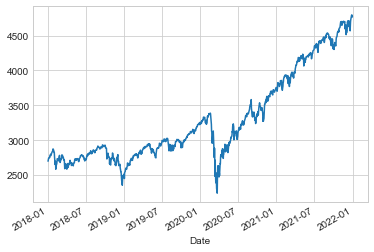

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
sp500.plot();

### Resampling and Converting Frequencies

One common need when dealing with time series data is resampling at a higher or lower frequency.
This can be done using the `resample` method, or the much simpler `asfreq` method.
The primary difference between the two is that `resample` is fundamentally a *data aggregation*, while `asfreq` is fundamentally a *data selection*.

Let's compare what the two return when we downsample the S&P 500 closing price data.
Here we will resample the data at the end of business year; the following figure shows the result:

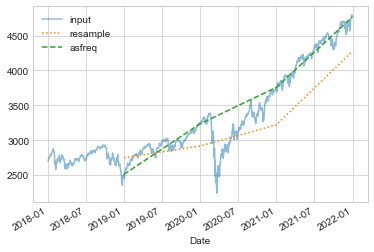

In [ ]:
sp500.plot(alpha=0.5, style='-')
sp500.resample('BA').mean().plot(style=':')
sp500.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Notice the difference: at each point, `resample` reports the *average of the previous year*, while `asfreq` reports the *value at the end of the year*.

For upsampling, `resample` and `asfreq` are largely equivalent, though `resample` has many more options available.
In this case, the default for both methods is to leave the upsampled points empty; that is, filled with NA values.
Like the `pd.fillna` function discussed in [Handling Missing Data](03.04-Missing-Values.ipynb), `asfreq` accepts a `method` argument to specify how values are imputed.
Here, we will resample the business day data at a daily frequency (i.e., including weekends); the following figure shows the result:

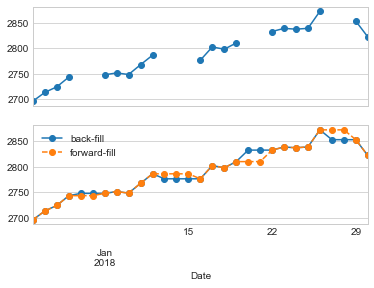

In [ ]:
fig, ax = plt.subplots(2, sharex=True)
data = sp500.iloc[:20]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

Because the S&P 500 data only exists for business days, the top panel has gaps representing NA values.
The bottom panel shows the differences between two strategies for filling the gaps: forward filling and backward filling.

### Time Shifts

Another common time series–specific operation is shifting of data in time.
For this, Pandas provides the `shift` method, which can be used to shift data by a given number of entries.
With time series data sampled at a regular frequency, this can give us a way to explore trends over time.

For example, here we resample the data to daily values, and shift by 364 to compute the 1-year return on investment for the S&P 500 over time (see the following figure):

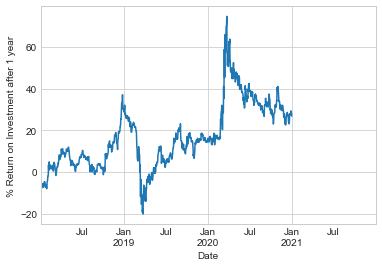

In [ ]:
sp500 = sp500.asfreq('D', method='pad')

ROI = 100 * (sp500.shift(-365) - sp500) / sp500
ROI.plot()
plt.ylabel('% Return on Investment after 1 year');

The worst one-year return was around March 2019, with the coronavirus-related market crash exactly a year later. As you might expect, the best one-year return was to be found in March 2020, for those with enough foresight or luck to buy low.

### Rolling Windows

Calculating rolling statistics is a third type of time series–specific operation implemented by Pandas.
This can be accomplished via the `rolling` attribute of `Series` and `DataFrame` objects, which returns a view similar to what we saw with the `groupby` operation (see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb)).
This rolling view makes available a number of aggregation operations by default.



For example, we can look at the one-year centered rolling mean and standard deviation of the  stock prices (see the following figure):

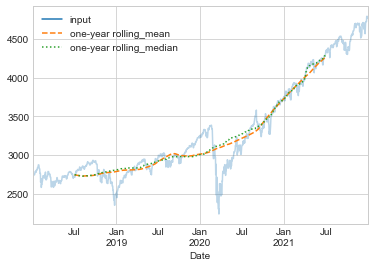

In [ ]:
rolling = sp500.rolling(365, center=True)

data = pd.DataFrame({'input': sp500,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_median': rolling.median()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

As with `groupby` operations, the `aggregate` and `apply` methods can be used for custom rolling computations.

## Where to Learn More

This chapter has provided only a brief summary of some of the most essential features of time series tools provided by Pandas; for a more complete discussion, you can refer to the ["Time Series/Date Functionality" section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) of the Pandas online documentation.

Another excellent resource is the book [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781098104023/) by Wes McKinney (O'Reilly).
It is an invaluable resource on the use of Pandas.
In particular, this book emphasizes time series tools in the context of business and finance, and focuses much more on particular details of business calendars, time zones, and related topics.

As always, you can also use the IPython help functionality to explore and try out further options available to the functions and methods discussed here. I find this often is the best way to learn a new Python tool.

## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with time series data, let's take a look at bicycle counts on Seattle's [Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).
This data comes from an automated bicycle counter installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The hourly bicycle counts can be downloaded from [http://data.seattle.gov](http://data.seattle.gov); the Fremont Bridge Bicycle Counter dataset is available under the Transportation category.

The CSV used for this book can be downloaded as follows:

In [ ]:
# url = ('https://raw.githubusercontent.com/jakevdp/'
#        'bicycle-data/main/FremontBridge.csv')
# !curl -O {url}

Once this dataset is downloaded, we can use Pandas to read the CSV output into a `DataFrame`.
We will specify that we want the `Date` column as an index, and we want these dates to be automatically parsed:

In [ ]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


For convenience, we'll shorten the column names:

In [ ]:
data.columns = ['Total', 'East', 'West']

Now let's take a look at the summary statistics for this data:

In [ ]:
data.dropna().describe()

,Total,East,West
count,147255.000000,147255.000000,147255.000000
mean,110.341462,50.077763,60.263699
std,140.422051,64.634038,87.252147
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,145.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


### Visualizing the Data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data (see the following figure):

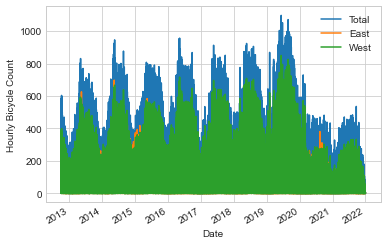

In [ ]:
data.plot()
plt.ylabel('Hourly Bicycle Count');

The ~150,000 hourly samples are far too dense for us to make much sense of.
We can gain more insight by resampling the data to a coarser grid.
Let's resample by week (see the following figure):

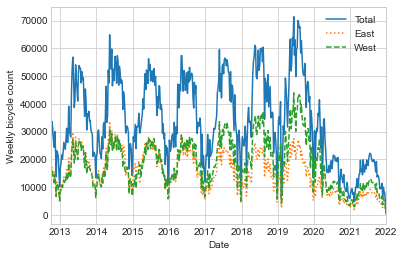

In [ ]:
weekly = data.resample('W').sum()
weekly.plot(style=['-', ':', '--'])
plt.ylabel('Weekly bicycle count');

This reveals some trends: as you might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather; see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), where we explore this further). Further, the effect of the COVID-19 pandemic on commuting patterns is quite clear, starting in early 2020.

Another option that comes in handy for aggregating the data is to use a rolling mean, utilizing the `pd.rolling_mean` function.
Here we'll examine the 30-day rolling mean of our data, making sure to center the window (see the following figure):

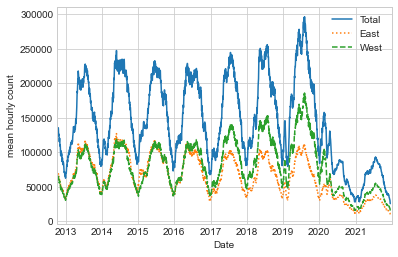

In [ ]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=['-', ':', '--'])
plt.ylabel('mean hourly count');

The jaggedness of the result is due to the hard cutoff of the window.
We can get a smoother version of a rolling mean using a window function—for example, a Gaussian window, as shown in the following figure.
The following code specifies both the width of the window (here, 50 days) and the width of the Gaussian window (here, 10 days):

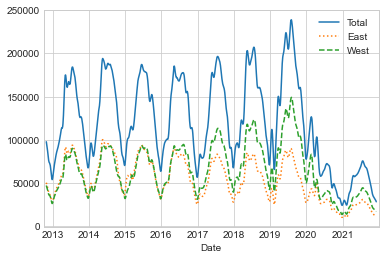

In [ ]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=['-', ':', '--']);

### Digging into the Data

While these smoothed data views are useful to get an idea of the general trend in the data, they hide much of the structure.
For example, we might want to look at the average traffic as a function of the time of day.
We can do this using the `groupby` functionality discussed in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) (see the following figure):

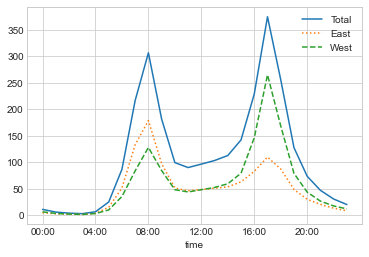

In [ ]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', ':', '--']);

The hourly traffic is a strongly bimodal sequence, with peaks around 8:00 a.m. and 5:00 p.m.
This is likely evidence of a strong component of commuter traffic crossing the bridge.
There is a directional component as well: according to the data, the east sidewalk is used more during the a.m. commute, and the west sidewalk is used more during the p.m. commute.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple `groupby` (see the following figure):

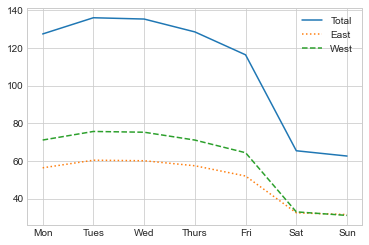

In [ ]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', ':', '--']);

This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound `groupby` and look at the hourly trends on weekdays versus weekends.
We'll start by grouping by flags marking the weekend and the time of day:

In [ ]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

Now we'll use some of the Matplotlib tools that will be described in [Multiple Subplots](04.08-Multiple-Subplots.ipynb) to plot two panels side by side, as shown in the following figure:

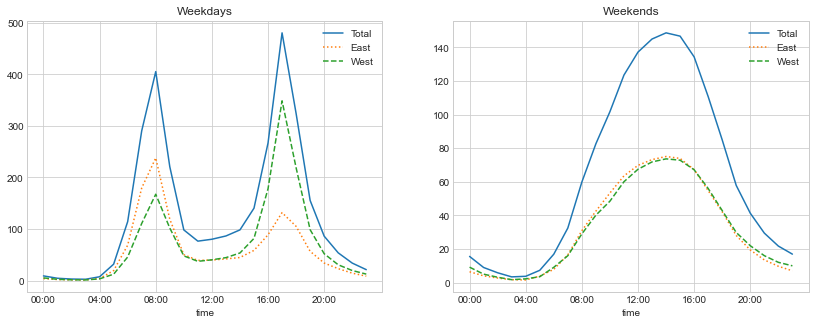

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                            xticks=hourly_ticks, style=['-', ':', '--'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                            xticks=hourly_ticks, style=['-', ':', '--']);

The result shows a bimodal commuting pattern during the work week, and a unimodal recreational pattern during the weekends.
It might be interesting to dig through this data in more detail and examine the effects of weather, temperature, time of year, and other factors on people's commuting patterns; for further discussion, see my blog post ["Is Seattle Really Seeing an Uptick in Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), which uses a subset of this data.
We will also revisit this dataset in the context of modeling in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).

# High-Performance Pandas: eval and query

As we've already seen in previous chapters, the power of the PyData stack is built upon the ability of NumPy and Pandas to push basic operations into lower-level compiled code via an intuitive higher-level syntax: examples are vectorized/broadcasted operations in NumPy, and grouping-type operations in Pandas.
While these abstractions are efficient and effective for many common use cases, they often rely on the creation of temporary intermediate objects, which can cause undue overhead in computational time and memory use.

To address this, Pandas includes some methods that allow you to directly access C-speed operations without costly allocation of intermediate arrays: `eval` and `query`, which rely on the [NumExpr package](https://github.com/pydata/numexpr).
In this chapter I will walk you through their use and give some rules of thumb about when you might think about using them.

## Motivating query and eval: Compound Expressions

We've seen previously that NumPy and Pandas support fast vectorized operations; for example, when adding the elements of two arrays:

In [ ]:
import numpy as np
rng = np.random.default_rng(42)
x = rng.random(1000000)
y = rng.random(1000000)
%timeit x + y

2.21 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As discussed in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb), this is much faster than doing the addition via a Python loop or comprehension:

In [ ]:
%timeit np.fromiter((xi + yi for xi, yi in zip(x, y)),
                    dtype=x.dtype, count=len(x))

263 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


But this abstraction can become less efficient when computing compound expressions.
For example, consider the following expression:

In [ ]:
mask = (x > 0.5) & (y < 0.5)

Because NumPy evaluates each subexpression, this is roughly equivalent to the following:

In [ ]:
tmp1 = (x > 0.5)
tmp2 = (y < 0.5)
mask = tmp1 & tmp2

In other words, *every intermediate step is explicitly allocated in memory*. If the `x` and `y` arrays are very large, this can lead to significant memory and computational overhead.
The NumExpr library gives you the ability to compute this type of compound expression element by element, without the need to allocate full intermediate arrays.
The [NumExpr documentation](https://github.com/pydata/numexpr) has more details, but for the time being it is sufficient to say that the library accepts a *string* giving the NumPy-style expression you'd like to compute:

In [ ]:
import numexpr
mask_numexpr = numexpr.evaluate('(x > 0.5) & (y < 0.5)')
np.all(mask == mask_numexpr)

True

The benefit here is that NumExpr evaluates the expression in a way that avoids temporary arrays where possible, and thus can be much more efficient than NumPy, especially for long sequences of computations on large arrays.
The Pandas `eval` and `query` tools that we will discuss here are conceptually similar, and are essentially Pandas-specific wrappers of NumExpr functionality.

## pandas.eval for Efficient Operations

The `eval` function in Pandas uses string expressions to efficiently compute operations on `DataFrame` objects.
For example, consider the following data:

In [ ]:
import pandas as pd
nrows, ncols = 100000, 100
df1, df2, df3, df4 = (pd.DataFrame(rng.random((nrows, ncols)))
                      for i in range(4))

To compute the sum of all four ``DataFrame``s using the typical Pandas approach, we can just write the sum:

In [ ]:
%timeit df1 + df2 + df3 + df4

73.2 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The same result can be computed via ``pd.eval`` by constructing the expression as a string:

In [ ]:
%timeit pd.eval('df1 + df2 + df3 + df4')

34 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The `eval` version of this expression is about 50% faster (and uses much less memory), while giving the same result:

In [ ]:
np.allclose(df1 + df2 + df3 + df4,
            pd.eval('df1 + df2 + df3 + df4'))

True

`pd.eval` supports a wide range of operations.
To demonstrate these, we'll use the following integer data:

In [ ]:
df1, df2, df3, df4, df5 = (pd.DataFrame(rng.integers(0, 1000, (100, 3)))
                           for i in range(5))

#### Arithmetic operators
`pd.eval` supports all arithmetic operators. For example:

In [ ]:
result1 = -df1 * df2 / (df3 + df4) - df5
result2 = pd.eval('-df1 * df2 / (df3 + df4) - df5')
np.allclose(result1, result2)

True

#### Comparison operators
`pd.eval` supports all comparison operators, including chained expressions:

In [ ]:
result1 = (df1 < df2) & (df2 <= df3) & (df3 != df4)
result2 = pd.eval('df1 < df2 <= df3 != df4')
np.allclose(result1, result2)

True

#### Bitwise operators
`pd.eval` supports the `&` and `|` bitwise operators:

In [ ]:
result1 = (df1 < 0.5) & (df2 < 0.5) | (df3 < df4)
result2 = pd.eval('(df1 < 0.5) & (df2 < 0.5) | (df3 < df4)')
np.allclose(result1, result2)

True

In addition, it supports the use of the literal `and` and `or` in Boolean expressions:

In [ ]:
result3 = pd.eval('(df1 < 0.5) and (df2 < 0.5) or (df3 < df4)')
np.allclose(result1, result3)

True

#### Object attributes and indices

`pd.eval` supports access to object attributes via the `obj.attr` syntax and indexes via the `obj[index]` syntax:

In [ ]:
result1 = df2.T[0] + df3.iloc[1]
result2 = pd.eval('df2.T[0] + df3.iloc[1]')
np.allclose(result1, result2)

True

#### Other operations

Other operations, such as function calls, conditional statements, loops, and other more involved constructs are currently *not* implemented in `pd.eval`.
If you'd like to execute these more complicated types of expressions, you can use the NumExpr library itself.

## DataFrame.eval for Column-Wise Operations

Just as Pandas has a top-level `pd.eval` function, `DataFrame` objects have an `eval` method that works in similar ways.
The benefit of the `eval` method is that columns can be referred to by name.
We'll use this labeled array as an example:

In [ ]:
df = pd.DataFrame(rng.random((1000, 3)), columns=['A', 'B', 'C'])
df.head()

,A,B,C
0,0.850888,0.966709,0.958690
1,0.820126,0.385686,0.061402
2,0.059729,0.831768,0.652259
3,0.244774,0.140322,0.041711
4,0.818205,0.753384,0.578851


Using `pd.eval` as in the previous section, we can compute expressions with the three columns like this:

In [ ]:
result1 = (df['A'] + df['B']) / (df['C'] - 1)
result2 = pd.eval("(df.A + df.B) / (df.C - 1)")
np.allclose(result1, result2)

True

The `DataFrame.eval` method allows much more succinct evaluation of expressions with the columns:

In [ ]:
result3 = df.eval('(A + B) / (C - 1)')
np.allclose(result1, result3)

True

Notice here that we treat *column names as variables* within the evaluated expression, and the result is what we would wish.

### Assignment in DataFrame.eval

In addition to the options just discussed, `DataFrame.eval`  also allows assignment to any column.
Let's use the `DataFrame` from before, which has columns `'A'`, `'B'`, and `'C'`:

In [ ]:
df.head()

,A,B,C
0,0.850888,0.966709,0.958690
1,0.820126,0.385686,0.061402
2,0.059729,0.831768,0.652259
3,0.244774,0.140322,0.041711
4,0.818205,0.753384,0.578851


We can use `df.eval` to create a new column `'D'` and assign to it a value computed from the other columns:

In [ ]:
df.eval('D = (A + B) / C', inplace=True)
df.head()

,A,B,C,D
0,0.850888,0.966709,0.958690,1.895916
1,0.820126,0.385686,0.061402,19.638139
2,0.059729,0.831768,0.652259,1.366782
3,0.244774,0.140322,0.041711,9.232370
4,0.818205,0.753384,0.578851,2.715013


In the same way, any existing column can be modified:

In [ ]:
df.eval('D = (A - B) / C', inplace=True)
df.head()

,A,B,C,D
0,0.850888,0.966709,0.958690,-0.120812
1,0.820126,0.385686,0.061402,7.075399
2,0.059729,0.831768,0.652259,-1.183638
3,0.244774,0.140322,0.041711,2.504142
4,0.818205,0.753384,0.578851,0.111982


### Local Variables in DataFrame.eval

The `DataFrame.eval` method supports an additional syntax that lets it work with local Python variables.
Consider the following:

In [ ]:
column_mean = df.mean(1)
result1 = df['A'] + column_mean
result2 = df.eval('A + @column_mean')
np.allclose(result1, result2)

True

The `@` character here marks a *variable name* rather than a *column name*, and lets you efficiently evaluate expressions involving the two "namespaces": the namespace of columns, and the namespace of Python objects.
Notice that this `@` character is only supported by the `DataFrame.eval` *method*, not by the `pandas.eval` *function*, because the `pandas.eval` function only has access to the one (Python) namespace.

## The DataFrame.query Method

The `DataFrame` has another method based on evaluated strings, called `query`.
Consider the following:

In [ ]:
result1 = df[(df.A < 0.5) & (df.B < 0.5)]
result2 = pd.eval('df[(df.A < 0.5) & (df.B < 0.5)]')
np.allclose(result1, result2)

True

As with the example used in our discussion of `DataFrame.eval`, this is an expression involving columns of the `DataFrame`.
However, it cannot be expressed using the `DataFrame.eval` syntax!
Instead, for this type of filtering operation, you can use the `query` method:

In [ ]:
result2 = df.query('A < 0.5 and B < 0.5')
np.allclose(result1, result2)

True

In addition to being a more efficient computation, compared to the masking expression this is much easier to read and understand.
Note that the `query` method also accepts the `@` flag to mark local variables:

In [ ]:
Cmean = df['C'].mean()
result1 = df[(df.A < Cmean) & (df.B < Cmean)]
result2 = df.query('A < @Cmean and B < @Cmean')
np.allclose(result1, result2)

True

## Performance: When to Use These Functions

When considering whether to use `eval` and `query`, there are two considerations: *computation time* and *memory use*.
Memory use is the most predictable aspect. As already mentioned, every compound expression involving NumPy arrays or Pandas ``DataFrame``s will result in implicit creation of temporary arrays. For example, this:

In [ ]:
x = df[(df.A < 0.5) & (df.B < 0.5)]

is roughly equivalent to this:

In [ ]:
tmp1 = df.A < 0.5
tmp2 = df.B < 0.5
tmp3 = tmp1 & tmp2
x = df[tmp3]

If the size of the temporary ``DataFrame``s is significant compared to your available system memory (typically several gigabytes), then it's a good idea to use an `eval` or `query` expression.
You can check the approximate size of your array in bytes using this:

In [ ]:
df.values.nbytes

32000

On the performance side, `eval` can be faster even when you are not maxing out your system memory.
The issue is how your temporary objects compare to the size of the L1 or L2 CPU cache on your system (typically a few megabytes); if they are much bigger, then `eval` can avoid some potentially slow movement of values between the different memory caches.
In practice, I find that the difference in computation time between the traditional methods and the `eval`/`query` method is usually not significant—if anything, the traditional method is faster for smaller arrays!
The benefit of `eval`/`query` is mainly in the saved memory, and the sometimes cleaner syntax they offer.

We've covered most of the details of `eval` and `query` here; for more information on these, you can refer to the Pandas documentation.
In particular, different parsers and engines can be specified for running these queries; for details on this, see the discussion within the ["Enhancing Performance" section](https://pandas.pydata.org/pandas-docs/dev/user_guide/enhancingperf.html) of the documentation.

# Further Resources

In this part of the book, we've covered many of the basics of using Pandas effectively for data analysis.
Still, much has been omitted from our discussion.
To learn more about Pandas, I recommend the following resources:

- [Pandas online documentation](http://pandas.pydata.org/): This is the go-to source for complete documentation of the package. While the examples in the documentation tend to be based on small generated datasets, the description of the options is complete and generally very useful for understanding the use of various functions.

- [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781098104023/): Written by Wes McKinney (the original creator of Pandas), this book contains much more detail on the Pandas package than we had room for in this chapter. In particular, McKinney takes a deep dive into tools for time series, which were his bread and butter as a financial consultant. The book also has many entertaining examples of applying Pandas to gain insight from real-world datasets.

- [*Effective Pandas*](https://leanpub.com/effective-pandas): This short e-book by Pandas developer Tom Augspurger provides a succinct outline of using the full power of the Pandas library in an effective and idiomatic way.

- [Pandas on PyVideo](http://pyvideo.org/search?q=pandas): From PyCon to SciPy to PyData, many conferences have featured tutorials by Pandas developers and power users. The PyCon tutorials in particular tend to be given by very well-vetted presenters.

Using these resources, combined with the walkthrough given in these chapters, my hope is that you'll be poised to use Pandas to tackle any data analysis problem you come across!